In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('pd_speech_features.csv')


In [ ]:
df.shape


(756, 755)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [ ]:
df.describe()


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,...,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,...,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,...,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000,0.000000
25%,62.750000,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,...,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750,0.000000
50%,125.500000,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,...,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250,1.000000
75%,188.250000,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,...,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325,1.000000
max,251.000000,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,...,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700,1.000000


In [ ]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)


In [ ]:
columns = list(df.columns)
for col in columns:
	if col == 'class':
		continue

	filtered_columns = [col]
	for col1 in df.columns:
		if((col == col1) | (col == 'class')):
			continue

		val = df[col].corr(df[col1])

		if val > 0.7:
			# If the correlation between the two
			# features is more than 0.7 remove
			columns.remove(col1)
			continue
		else:
			filtered_columns.append(col1)

	# After each iteration filter out the columns
	# which are not highly correlated features.
	df = df[filtered_columns]
df.shape


(252, 287)

In [ ]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape


(252, 31)

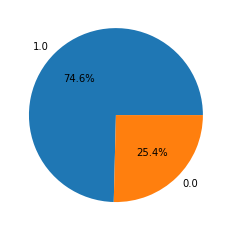

In [ ]:
x = df['class'].value_counts()
plt.pie(x.values,
		labels = x.index,
		autopct='%1.1f%%')
plt.show()


In [ ]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.2,
									random_state=10)
X_train.shape, X_val.shape


((201, 30), (51, 30))

In [ ]:
# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
						random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape


((302, 30), (302,))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X,Y)

LogisticRegression()

In [ ]:
train_pred = model.predict_proba(X)[:,1]
print("Training Accuracy: ",ras(Y,train_pred))

Training Accuracy:  0.8279461427130389


In [ ]:
val_preds = model.predict_proba(X_val)[:, 1]
print('Validation Accuracy : ', ras(Y_val, val_preds))


Validation Accuracy :  0.8127413127413127
